This is my first time using Jupyter Lab *and* Python 3, so we'll see how this goes.

In [2]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

### Read in the data

In [3]:
# This is the file that Song said to start with.
data_file_1 = '/Users/greg/Desktop/git_projects/catalog_plots/data/s16a_massive_logmMax_11.45_z_0.25_0.47_mhalo.fits'
hdu1 = fits.open(data_file_1)

So here I'm going to list the useful bits of this data set:

`ra`: Right Ascension

`dec`: Declination
(*These will be useful when I make the galaxy map plot*)

`z_best`: Best redshift value

`logm_max`: I think this is the mass I want for the radius. Or `logmh_host`?


In [4]:
data_table = Table(hdu1[1].data) # For visualization, just in case.

Now what I want to do is take the galaxy halo masses and assign them a radius. To do this, I will use  `Colossus` (Diemer 2017).

In [5]:
from colossus.cosmology import cosmology
cosmology.setCosmology('planck15')
from colossus.halo import mass_so

In [6]:
data_table.colnames # find the useful columns

['object_id',
 'ra',
 'dec',
 'z_spec',
 'z_best',
 'z_phot',
 'z_type',
 'gcmodel_mag',
 'gcmodel_mag_err',
 'rcmodel_mag',
 'rcmodel_mag_err',
 'icmodel_mag',
 'icmodel_mag_err',
 'zcmodel_mag',
 'zcmodel_mag_err',
 'ycmodel_mag',
 'ycmodel_mag_err',
 'MSTAR',
 'logm_10',
 'logm_30',
 'logm_100',
 'logm_max',
 'vdisp_sdss',
 'vdisp_err_sdss',
 'logms_gama',
 'logms_err_gama',
 'id_cluster_redm',
 'p_mem_redm',
 'z_lambda_redm',
 'lambda_redm',
 'p_cen_1_redm',
 'id_camira',
 'z_camira',
 'n_cor_camira',
 'logms_camira',
 'r50_max',
 'r50_100',
 'logmh_peak',
 'logmh_vir',
 'logmh_host']

In [7]:
# Put the data into nice arrays
z_best = np.array(data_table['z_best'])
logm_max = np.array(data_table['logm_max'])
ra = np.array(data_table['ra'])
dec = np.array(data_table['dec'])

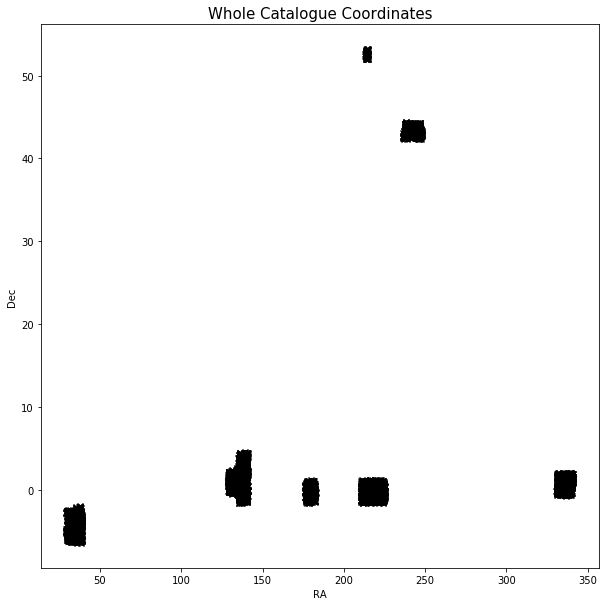

In [13]:
# First, I'm just going to plot the RA and Dec to be sure things line up.
plt.figure(figsize = [10,10])
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title("Whole Catalogue Coordinates", fontsize = 15)
plt.scatter(ra , dec, marker = 'x', color = 'k')